In [1]:
!pip install sktime
!pip install scalecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.9/21.9 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 62.5 MB/s eta 0:00:00
  Created wheel for scalecast: filename=SCALECAST-0.19.8-py3-none-any.whl size=125274 sha256=92687c9f0fdc95e0bcaebc30c617914a80c472e613abc6bacfbcdbc113acf79f
  Stored in directory: /root/.cache/pip/wheels/ac/67/2e/0244bcec7f41d76aae4c4196b64d31a20d474a7d5468f3d67e
Successfully built scalecast
  Attempting uninst

# Packages and plot functions

In [2]:
import itertools

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import sktime
from sktime.datasets import load_airline
from sktime.split import temporal_train_test_split
from sktime.utils.plotting import plot_series

from scalecast.Forecaster import Forecaster
from scalecast.MVForecaster import MVForecaster
from scalecast.multiseries import export_model_summaries
from scalecast import GridGenerator

In [3]:
np.random.seed(42)

plot_params = {'legend.fontsize': 20,
               'figure.figsize': (10, 8),
               'axes.labelsize':  15,
               'axes.titlesize':  20,
               'xtick.labelsize': 15,
               'ytick.labelsize': 15,
               'figure.dpi': 300}

plt.style.use('seaborn-v0_8')

plt.rcParams.update(plot_params)

color_dark_blue = [1/255, 62/255, 125/255]
color_light_blue = [6/255, 143/255, 203/255]
purple = [102/255, 51/255, 153/255]

colors = [color_dark_blue, color_light_blue, purple]

color_line = list(itertools.product(['-', ':', '--', ':' '-', ':'], colors))

For more information: https://github.com/mikekeith52/scalecast-examples/blob/main/multivariate/multivariate.ipynb

# Load Data

In [4]:
df1 = pd.read_csv('df_NS.csv', index_col=0)['PC 1 - Level'].diff().dropna().to_frame()
df1.index = pd.DatetimeIndex(df1.index).to_period('D')
df1 = df1.resample('M').sum()
df1 = df1.cumsum()
df1.index = df1.index.to_timestamp('M').strftime('%Y-%m')

In [5]:
df2 = pd.read_csv('df_NS.csv', index_col=0)['PC 2 - Slope'].diff().dropna().to_frame()
df2.index = pd.DatetimeIndex(df2.index).to_period('D')
df2 = df2.resample('M').sum()
df2 = df2.cumsum()
df2.index = df2.index.to_timestamp('M').strftime('%Y-%m')

# Univariate Forecast

In [6]:
#models = ('mlr','elasticnet','knn','rf','gbt','xgboost','mlp')
models = ('mlr','gbt', 'xgboost')
GridGenerator.get_example_grids()
GridGenerator.get_mv_grids()

In [7]:
f1 = Forecaster(
    y=df1['PC 1 - Level'],
    current_dates = df1.index,
    test_length = .2,
    future_dates = 12,
    validation_length = 12,
    metrics = ['rmse','r2'],
    cis = False,
)
f1

Forecaster(
    DateStartActuals=1985-11-01T00:00:00.000000000
    DateEndActuals=2023-11-01T00:00:00.000000000
    Freq=MS
    N_actuals=457
    ForecastLength=12
    Xvars=[]
    TestLength=91
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [8]:
f2 = Forecaster(
    y=df2['PC 2 - Slope'],
    current_dates = df1.index,
    test_length = .2,
    future_dates = 12,
    validation_length = 12,
    metrics = ['rmse','r2'],
    cis = False,
)
f2

Forecaster(
    DateStartActuals=1985-11-01T00:00:00.000000000
    DateEndActuals=2023-11-01T00:00:00.000000000
    Freq=MS
    N_actuals=457
    ForecastLength=12
    Xvars=[]
    TestLength=91
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

In [9]:
for f in (f1,f2):
    f.auto_Xvar_select(
        estimator = 'elasticnet',
        monitor = 'ValidationMetricValue',
        #irr_cycles = [26], # try irregular semi-annual seaosnality
        cross_validate=True,
        cvkwargs={
            'k':3,
            'test_length':12,
            'space_between_sets':4,
        }
    )
    print(f)

Forecaster(
    DateStartActuals=1985-11-01T00:00:00.000000000
    DateEndActuals=2023-11-01T00:00:00.000000000
    Freq=MS
    N_actuals=457
    ForecastLength=12
    Xvars=['AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24', 'AR25', 'AR26', 'AR27', 'AR28', 'AR29', 'AR30', 'AR31', 'AR32', 'AR33', 'AR34', 'AR35', 'AR36', 'AR37', 'AR38', 'AR39', 'AR40', 'AR41', 'AR42', 'AR43', 'AR44', 'AR45', 'AR46', 'AR47', 'AR48', 'AR49', 'AR50', 'AR51', 'AR52', 'AR53', 'AR54', 'AR55', 'AR56', 'AR57', 'AR58', 'AR59', 'AR60', 'AR61', 'AR62', 'AR63', 'AR64', 'AR65', 'AR66', 'AR67', 'AR68', 'AR69', 'AR70', 'AR71', 'AR72', 'AR73', 'AR74', 'AR75', 'AR76', 'AR77', 'AR78', 'AR79', 'AR80', 'AR81', 'AR82', 'AR83', 'AR84', 'AR85', 'AR86', 'AR87', 'AR88', 'AR89', 'AR90', 'AR91']
    TestLength=91
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimato

In [10]:
f1.tune_test_forecast(models)#,feature_importance=True)
best_model_con_uni = f1.order_fcsts()[0]
f1.set_estimator('combo')
f1.manual_forecast(how='weighted')

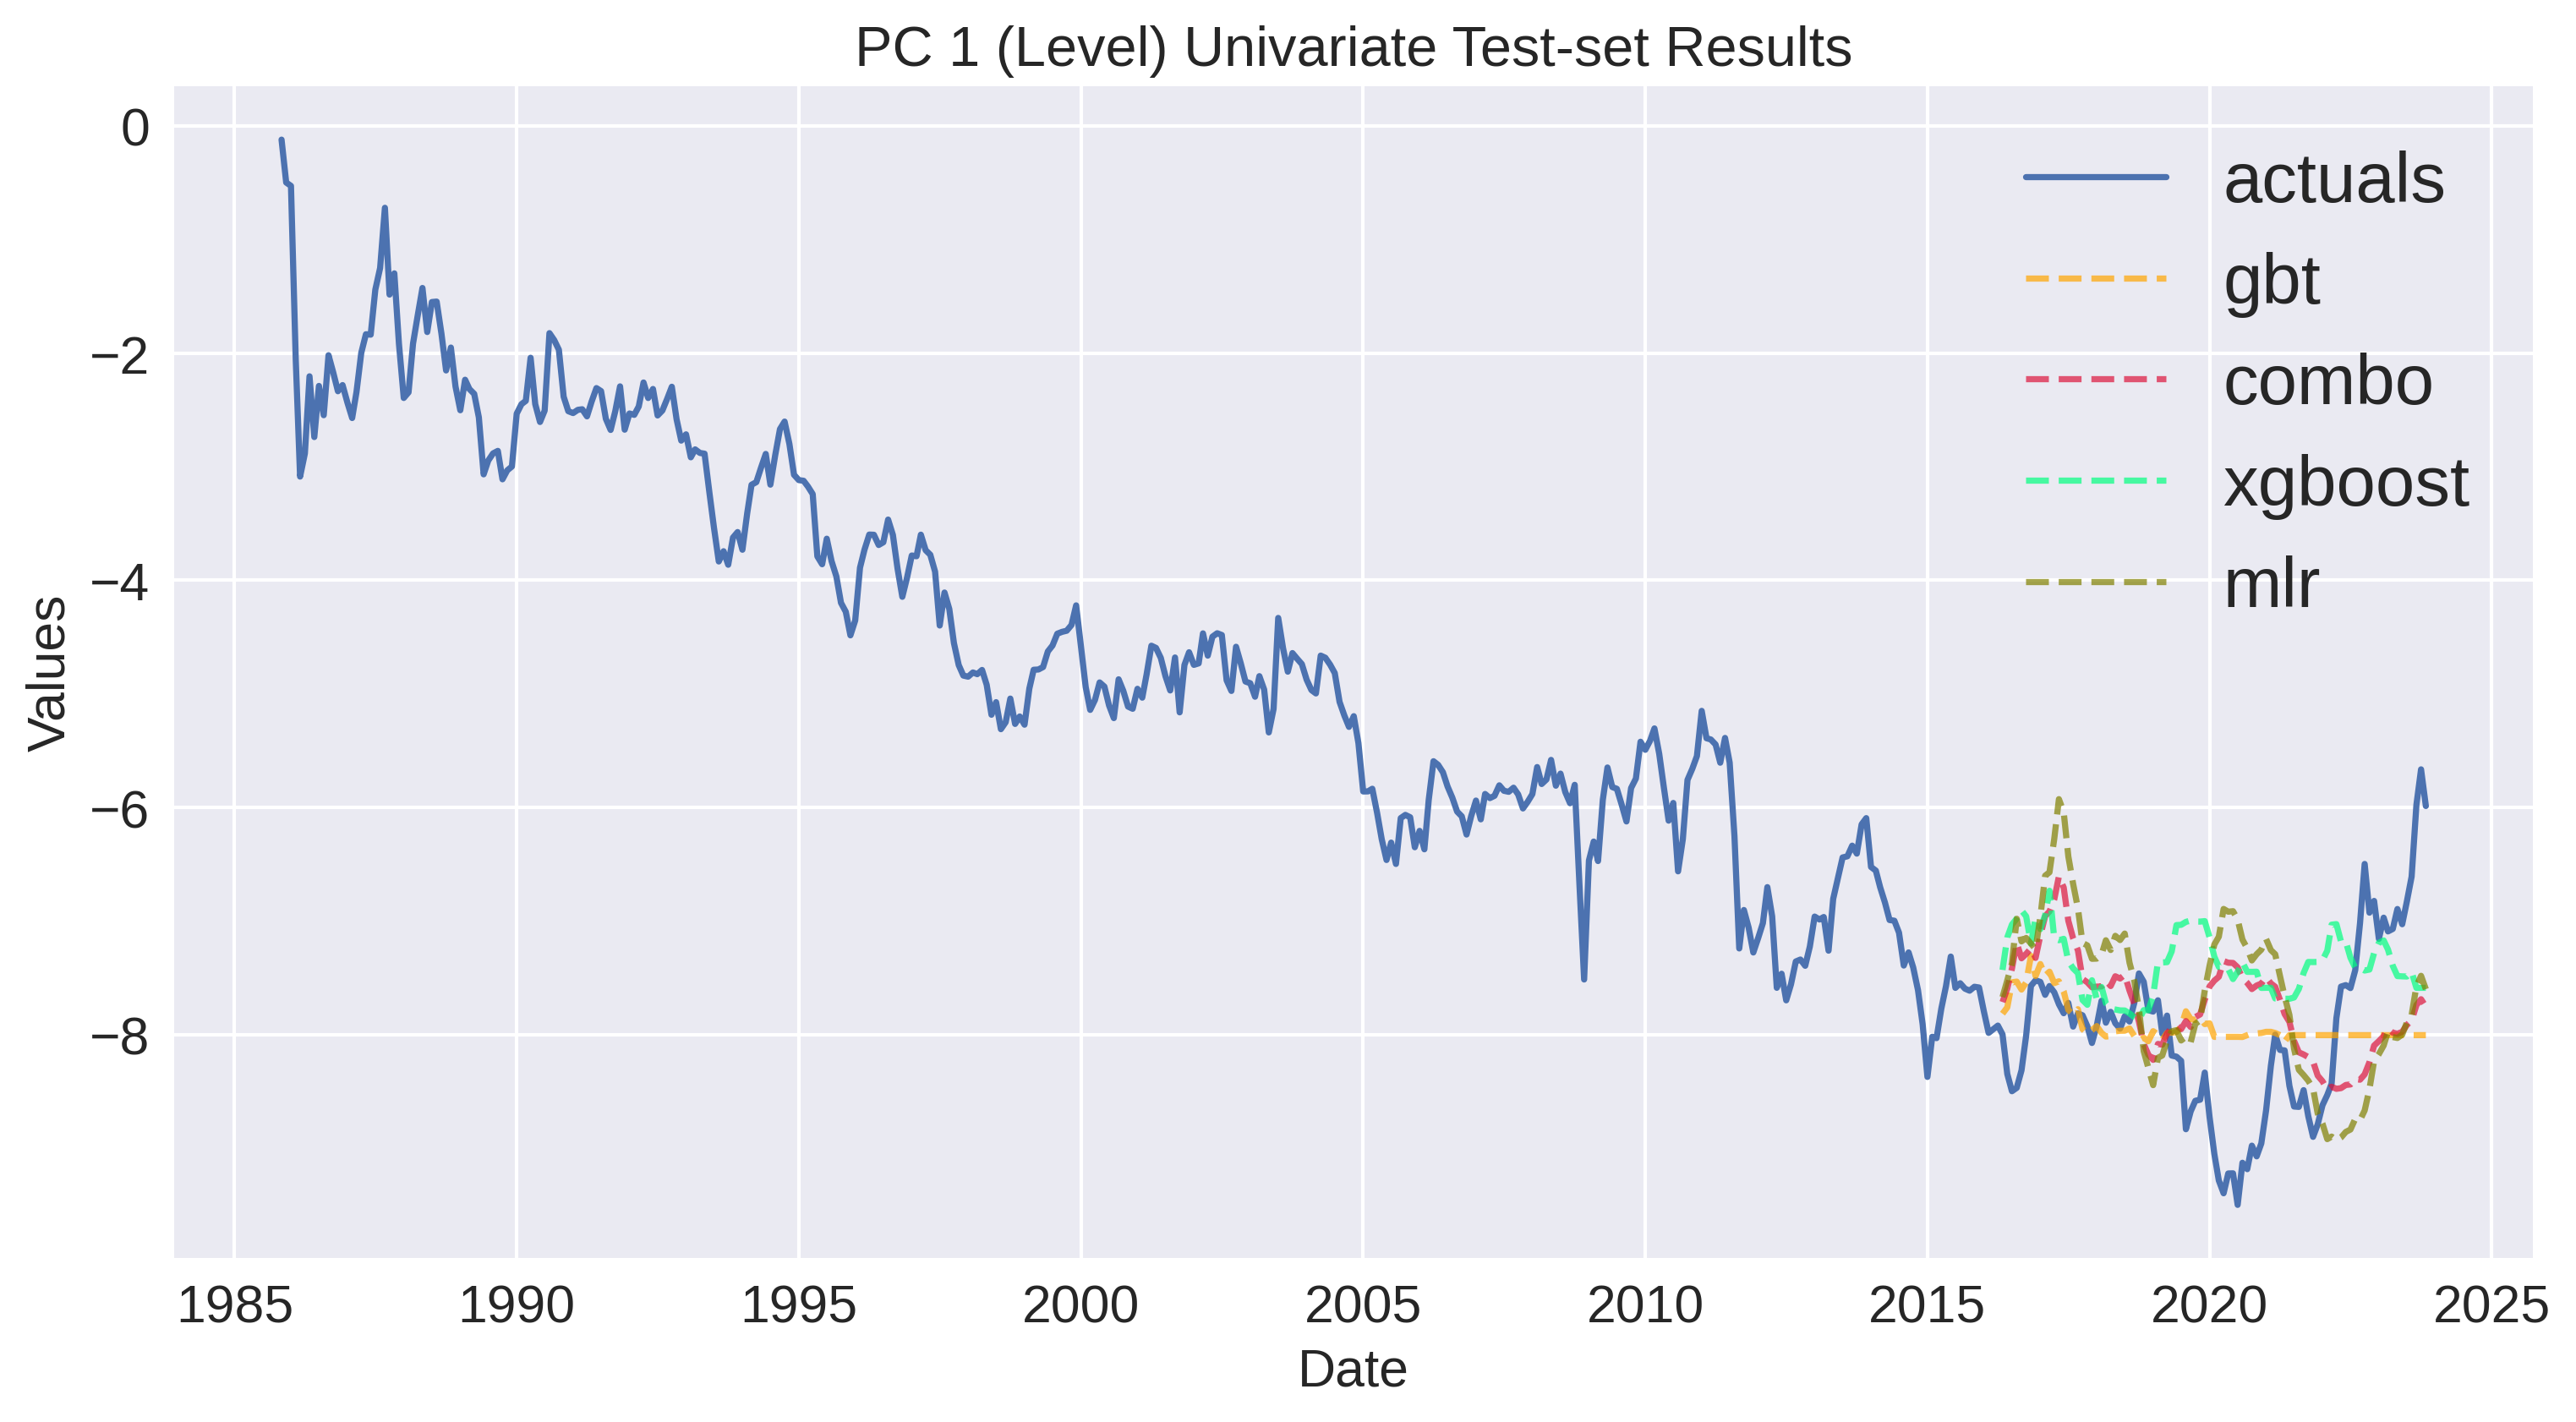

In [11]:
f1.plot_test_set(order_by='TestSetRMSE')
plt.title('PC 1 (Level) Univariate Test-set Results',size=16)
plt.show()

In [12]:
f2.tune_test_forecast(models)#,feature_importance=True)
best_model_con_uni = f2.order_fcsts()[0]
f2.set_estimator('combo')
f2.manual_forecast(how='weighted')

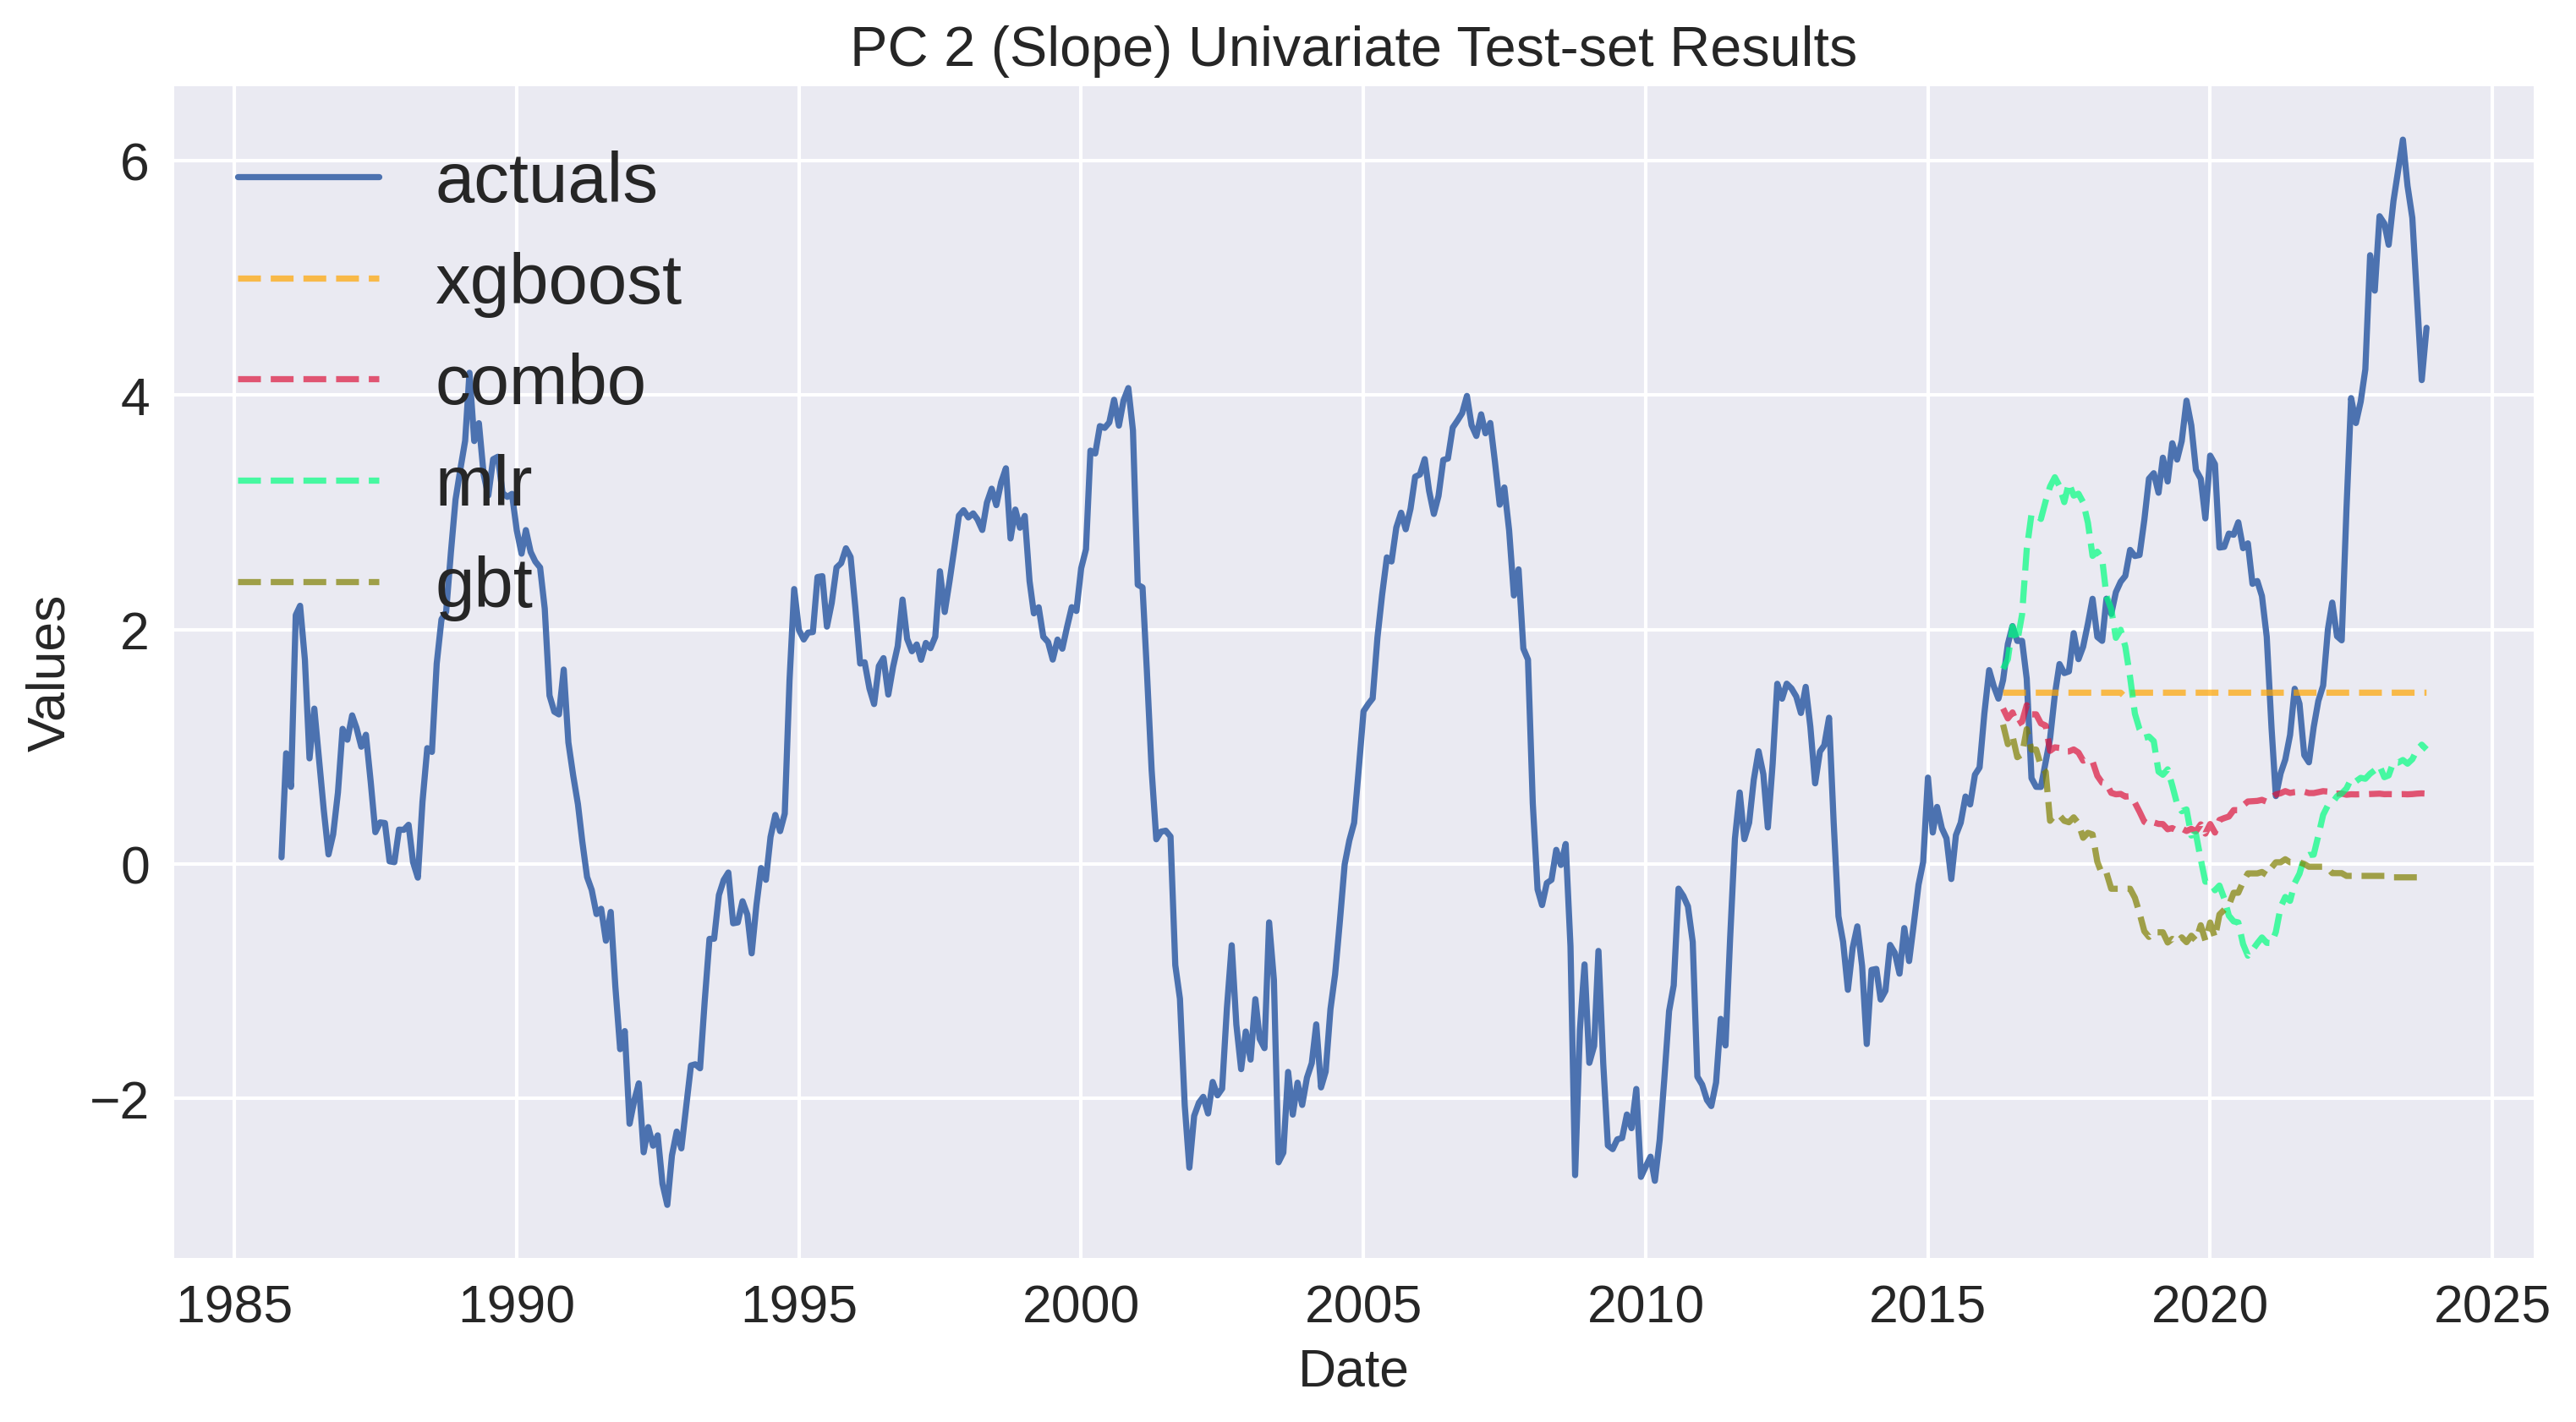

In [13]:
f2.plot_test_set(order_by='TestSetRMSE')
plt.title('PC 2 (Slope) Univariate Test-set Results',size=16)
plt.show()

In [14]:
pd.set_option('display.float_format',  '{:.4f}'.format)
ms = export_model_summaries({'PC 1 - Level':f1,'PC 2 - Slope':f2},determine_best_by='TestSetRMSE')
ms[
    [
        'ModelNickname',
        'Series',
        'TestSetRMSE',
        'TestSetR2',
        'InSampleRMSE',
        'InSampleR2',
        'best_model'
    ]
]

,ModelNickname,Series,TestSetRMSE,TestSetR2,InSampleRMSE,InSampleR2,best_model
0,gbt,PC 1 - Level,0.7937,-0.0433,0.0795,0.9976,True
1,combo,PC 1 - Level,0.9683,-0.5529,0.1441,0.9920,False
2,xgboost,PC 1 - Level,1.0350,-0.7742,0.0005,1.0000,False
3,mlr,PC 1 - Level,1.1613,-1.2337,0.2135,0.9824,False
4,xgboost,PC 2 - Slope,1.8633,-0.8096,0.3653,0.9681,True
5,combo,PC 2 - Slope,2.5673,-2.4357,0.2944,0.9793,False
6,mlr,PC 2 - Slope,2.6423,-2.6393,0.3653,0.9681,False
7,gbt,PC 2 - Slope,3.1942,-4.3183,0.2777,0.9816,False


In [15]:
print('-'*100)
for series in ms['Series'].unique():
    print('univariate average test MAPE for {}: {:.4f}'.format(series,ms.loc[ms['Series'] == series,'TestSetRMSE'].mean()))
    print('univariate average test R2 for {}: {:.2f}'.format(series,ms.loc[ms['Series'] == series,'TestSetR2'].mean()))
    print('-'*100)

----------------------------------------------------------------------------------------------------
univariate average test MAPE for PC 1 - Level: 0.9896
univariate average test R2 for PC 1 - Level: -0.65
----------------------------------------------------------------------------------------------------
univariate average test MAPE for PC 2 - Slope: 2.5668
univariate average test R2 for PC 2 - Slope: -2.55
----------------------------------------------------------------------------------------------------


# Multivariate Forecasting

In [16]:
mvf = MVForecaster(
    f1,f2,
    names=['PC 1 - Level','PC 2 - Slope'],
    test_length = .2,
    valiation_length = 4,
    cis = False,
    metrics = ['rmse','r2'],
) # init the mvf object
mvf

MVForecaster(
    DateStartActuals=1985-11-01T00:00:00.000000000
    DateEndActuals=2023-11-01T00:00:00.000000000
    Freq=MS
    N_actuals=457
    N_series=2
    SeriesNames=['PC 1 - Level', 'PC 2 - Slope']
    ForecastLength=12
    Xvars=[]
    TestLength=91
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    OptimizeOn=mean
    GridsFile=MVGrids
)

In [17]:
mvf.corr()

,PC 1 - Level,PC 2 - Slope
PC 1 - Level,1.0000,-0.2228
PC 2 - Slope,-0.2228,1.0000


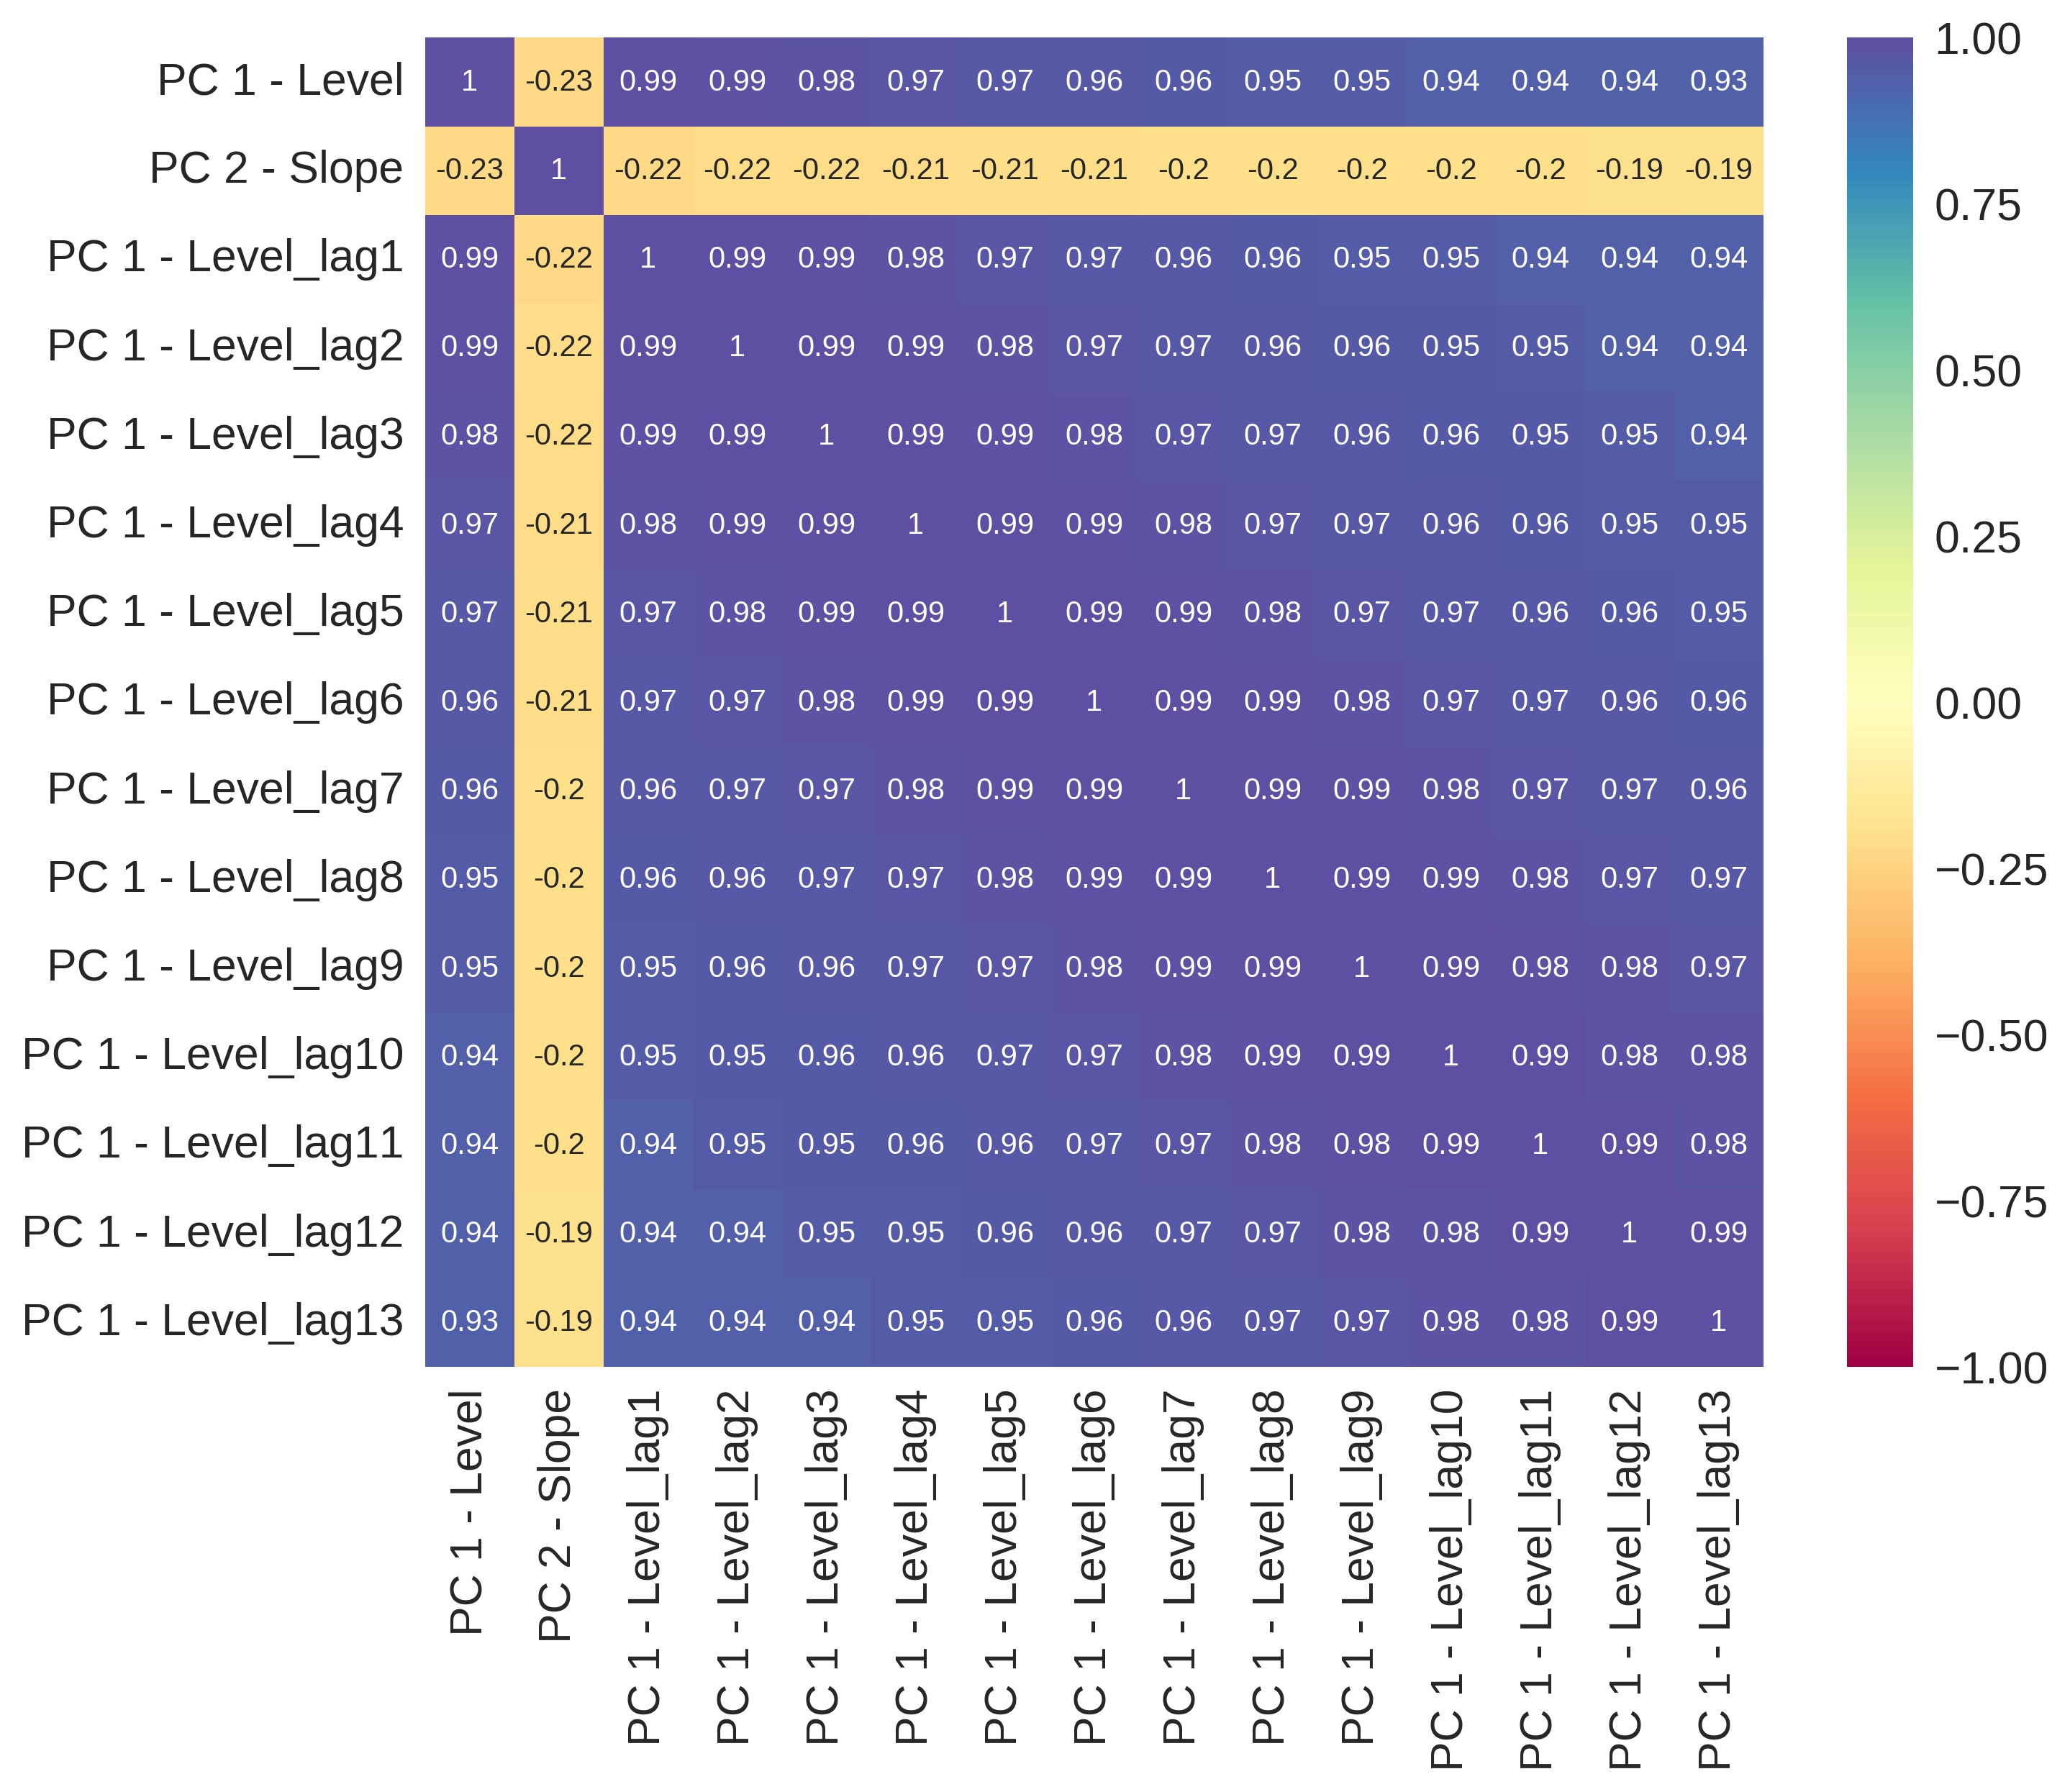

In [18]:
mvf.corr_lags(
    y='PC 2 - Slope',
    x='PC 1 - Level',
    lags=13,
    disp='heatmap',
    annot=True,
    vmin=-1,
    vmax=1,
    cmap = 'Spectral',
)
plt.show()

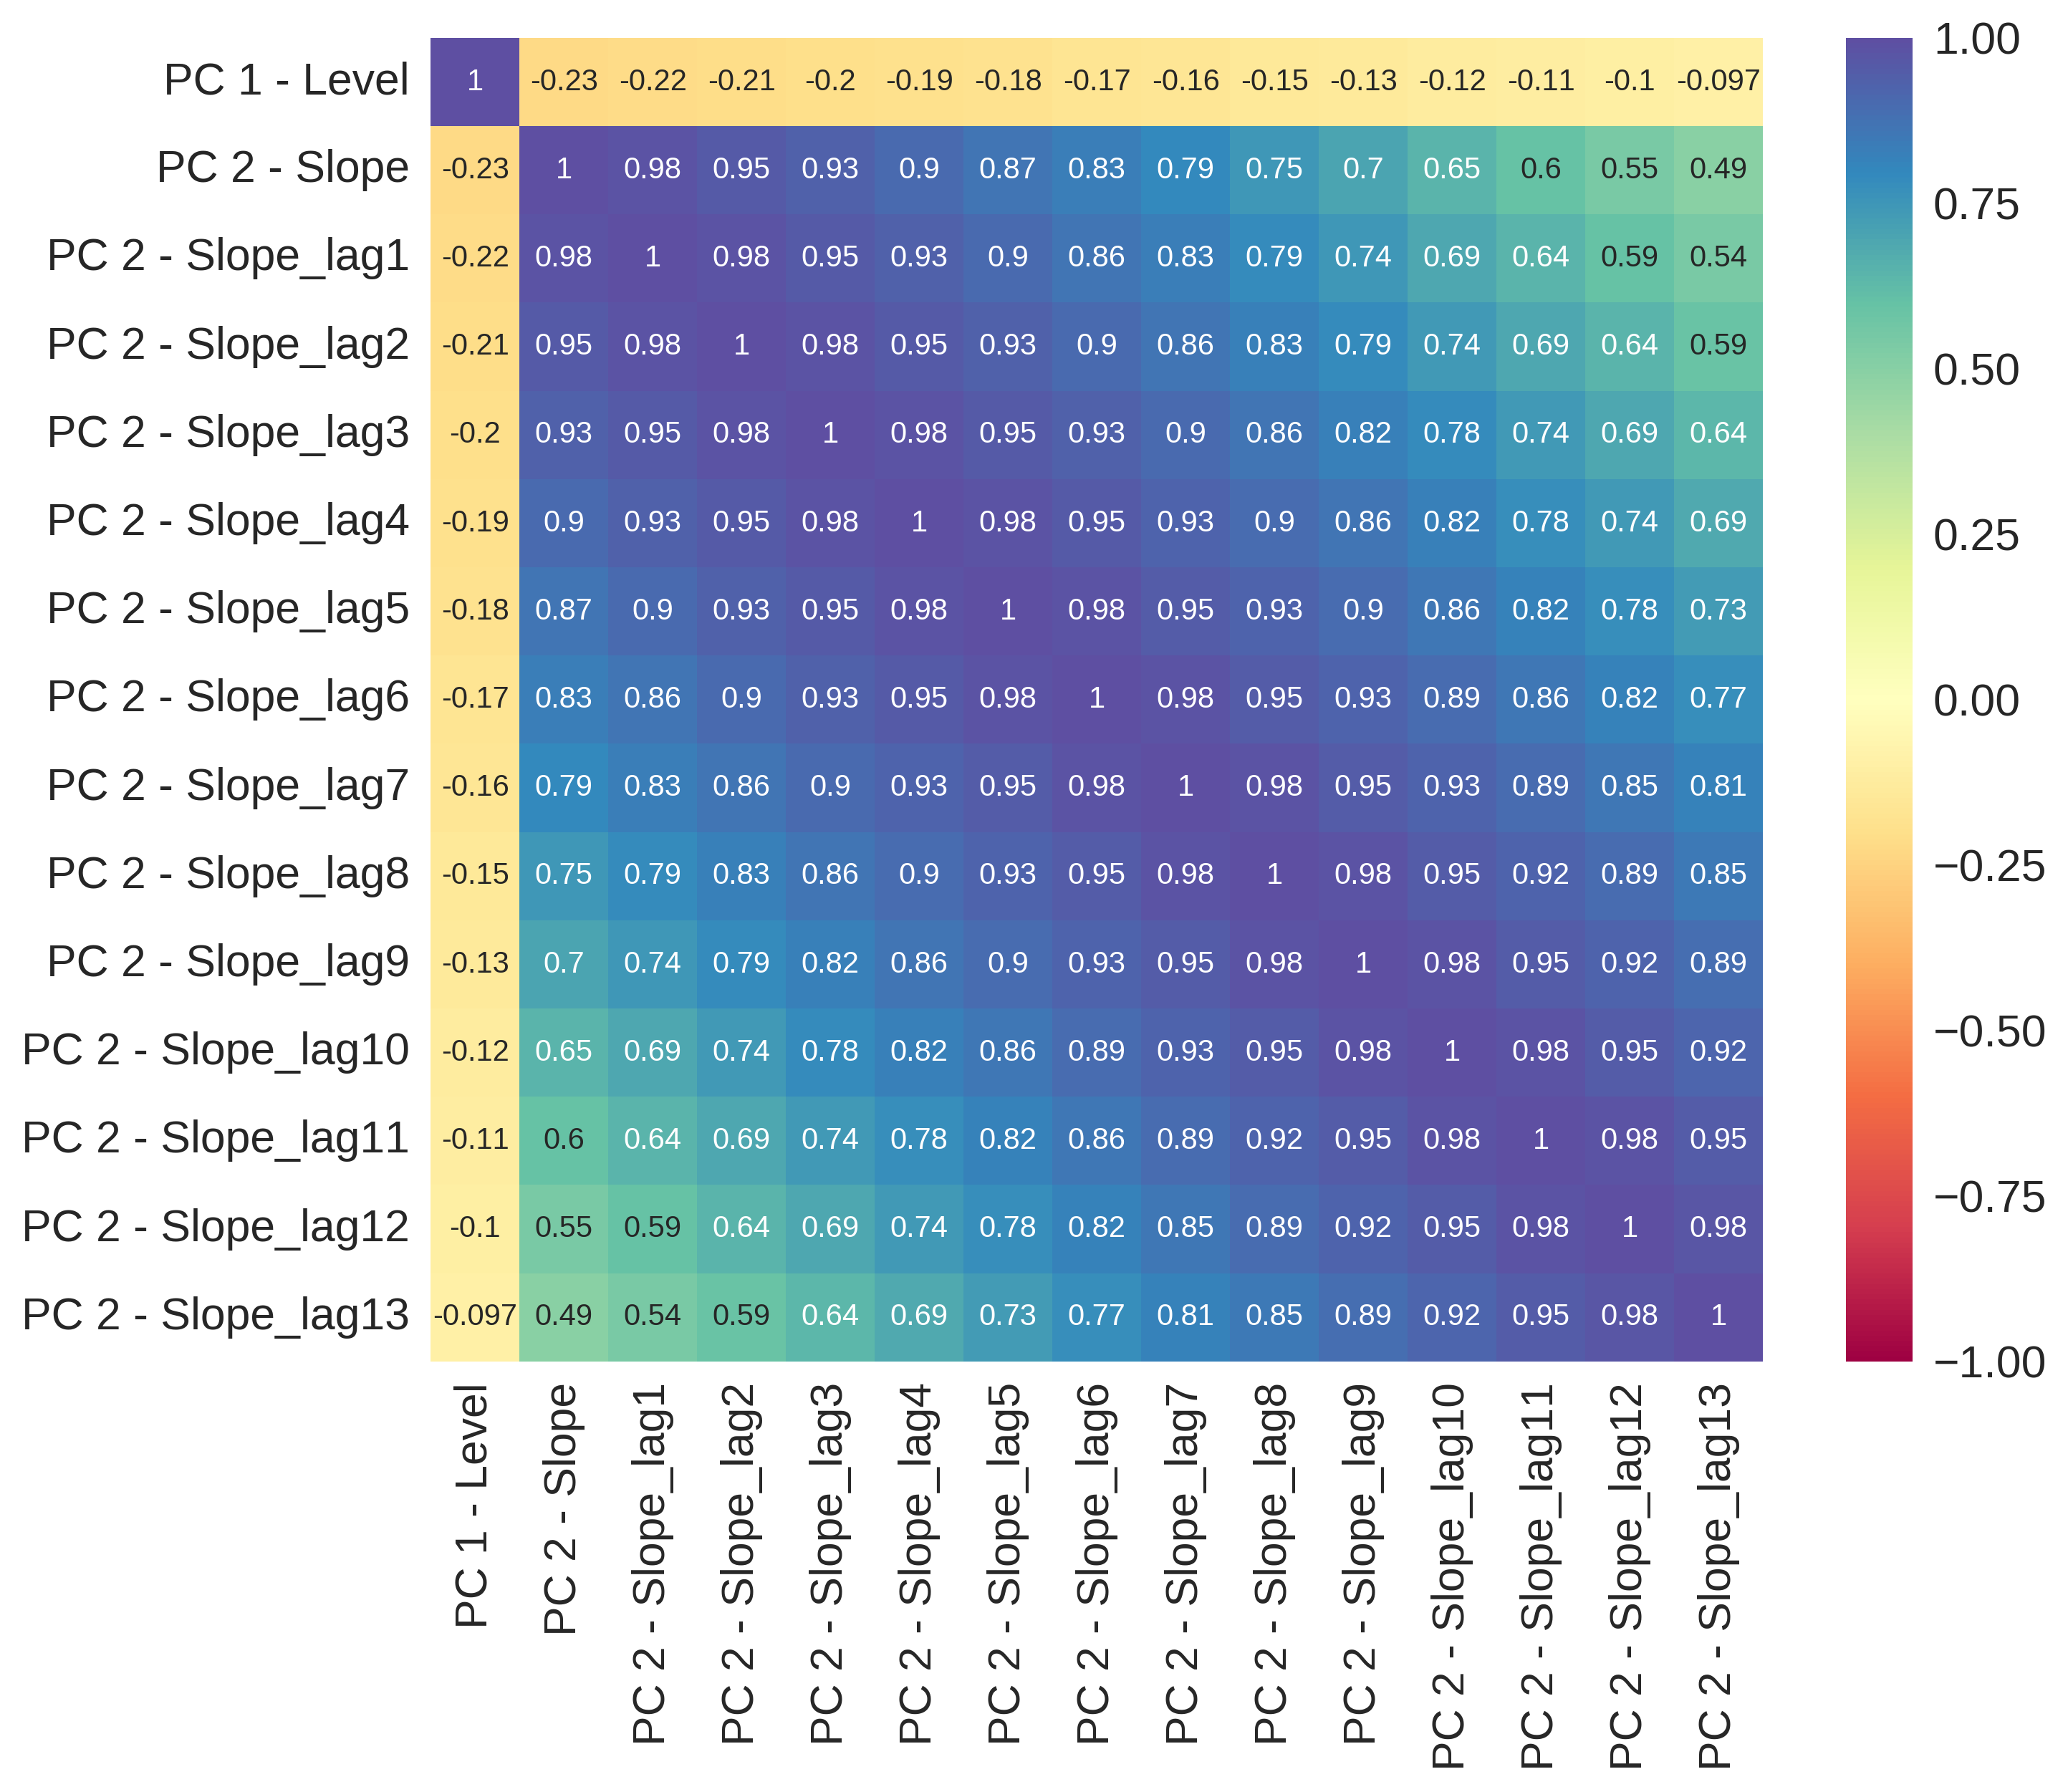

In [19]:
mvf.corr_lags(
    y='PC 1 - Level',
    x='PC 2 - Slope',
    lags=13,
    disp='heatmap',
    annot=True,
    vmin=-1,
    vmax=1,
    cmap = 'Spectral',
)
plt.show()

In [20]:
mvf.tune_test_forecast(models)
mvf.set_best_model(determine_best_by='TestSetRMSE')

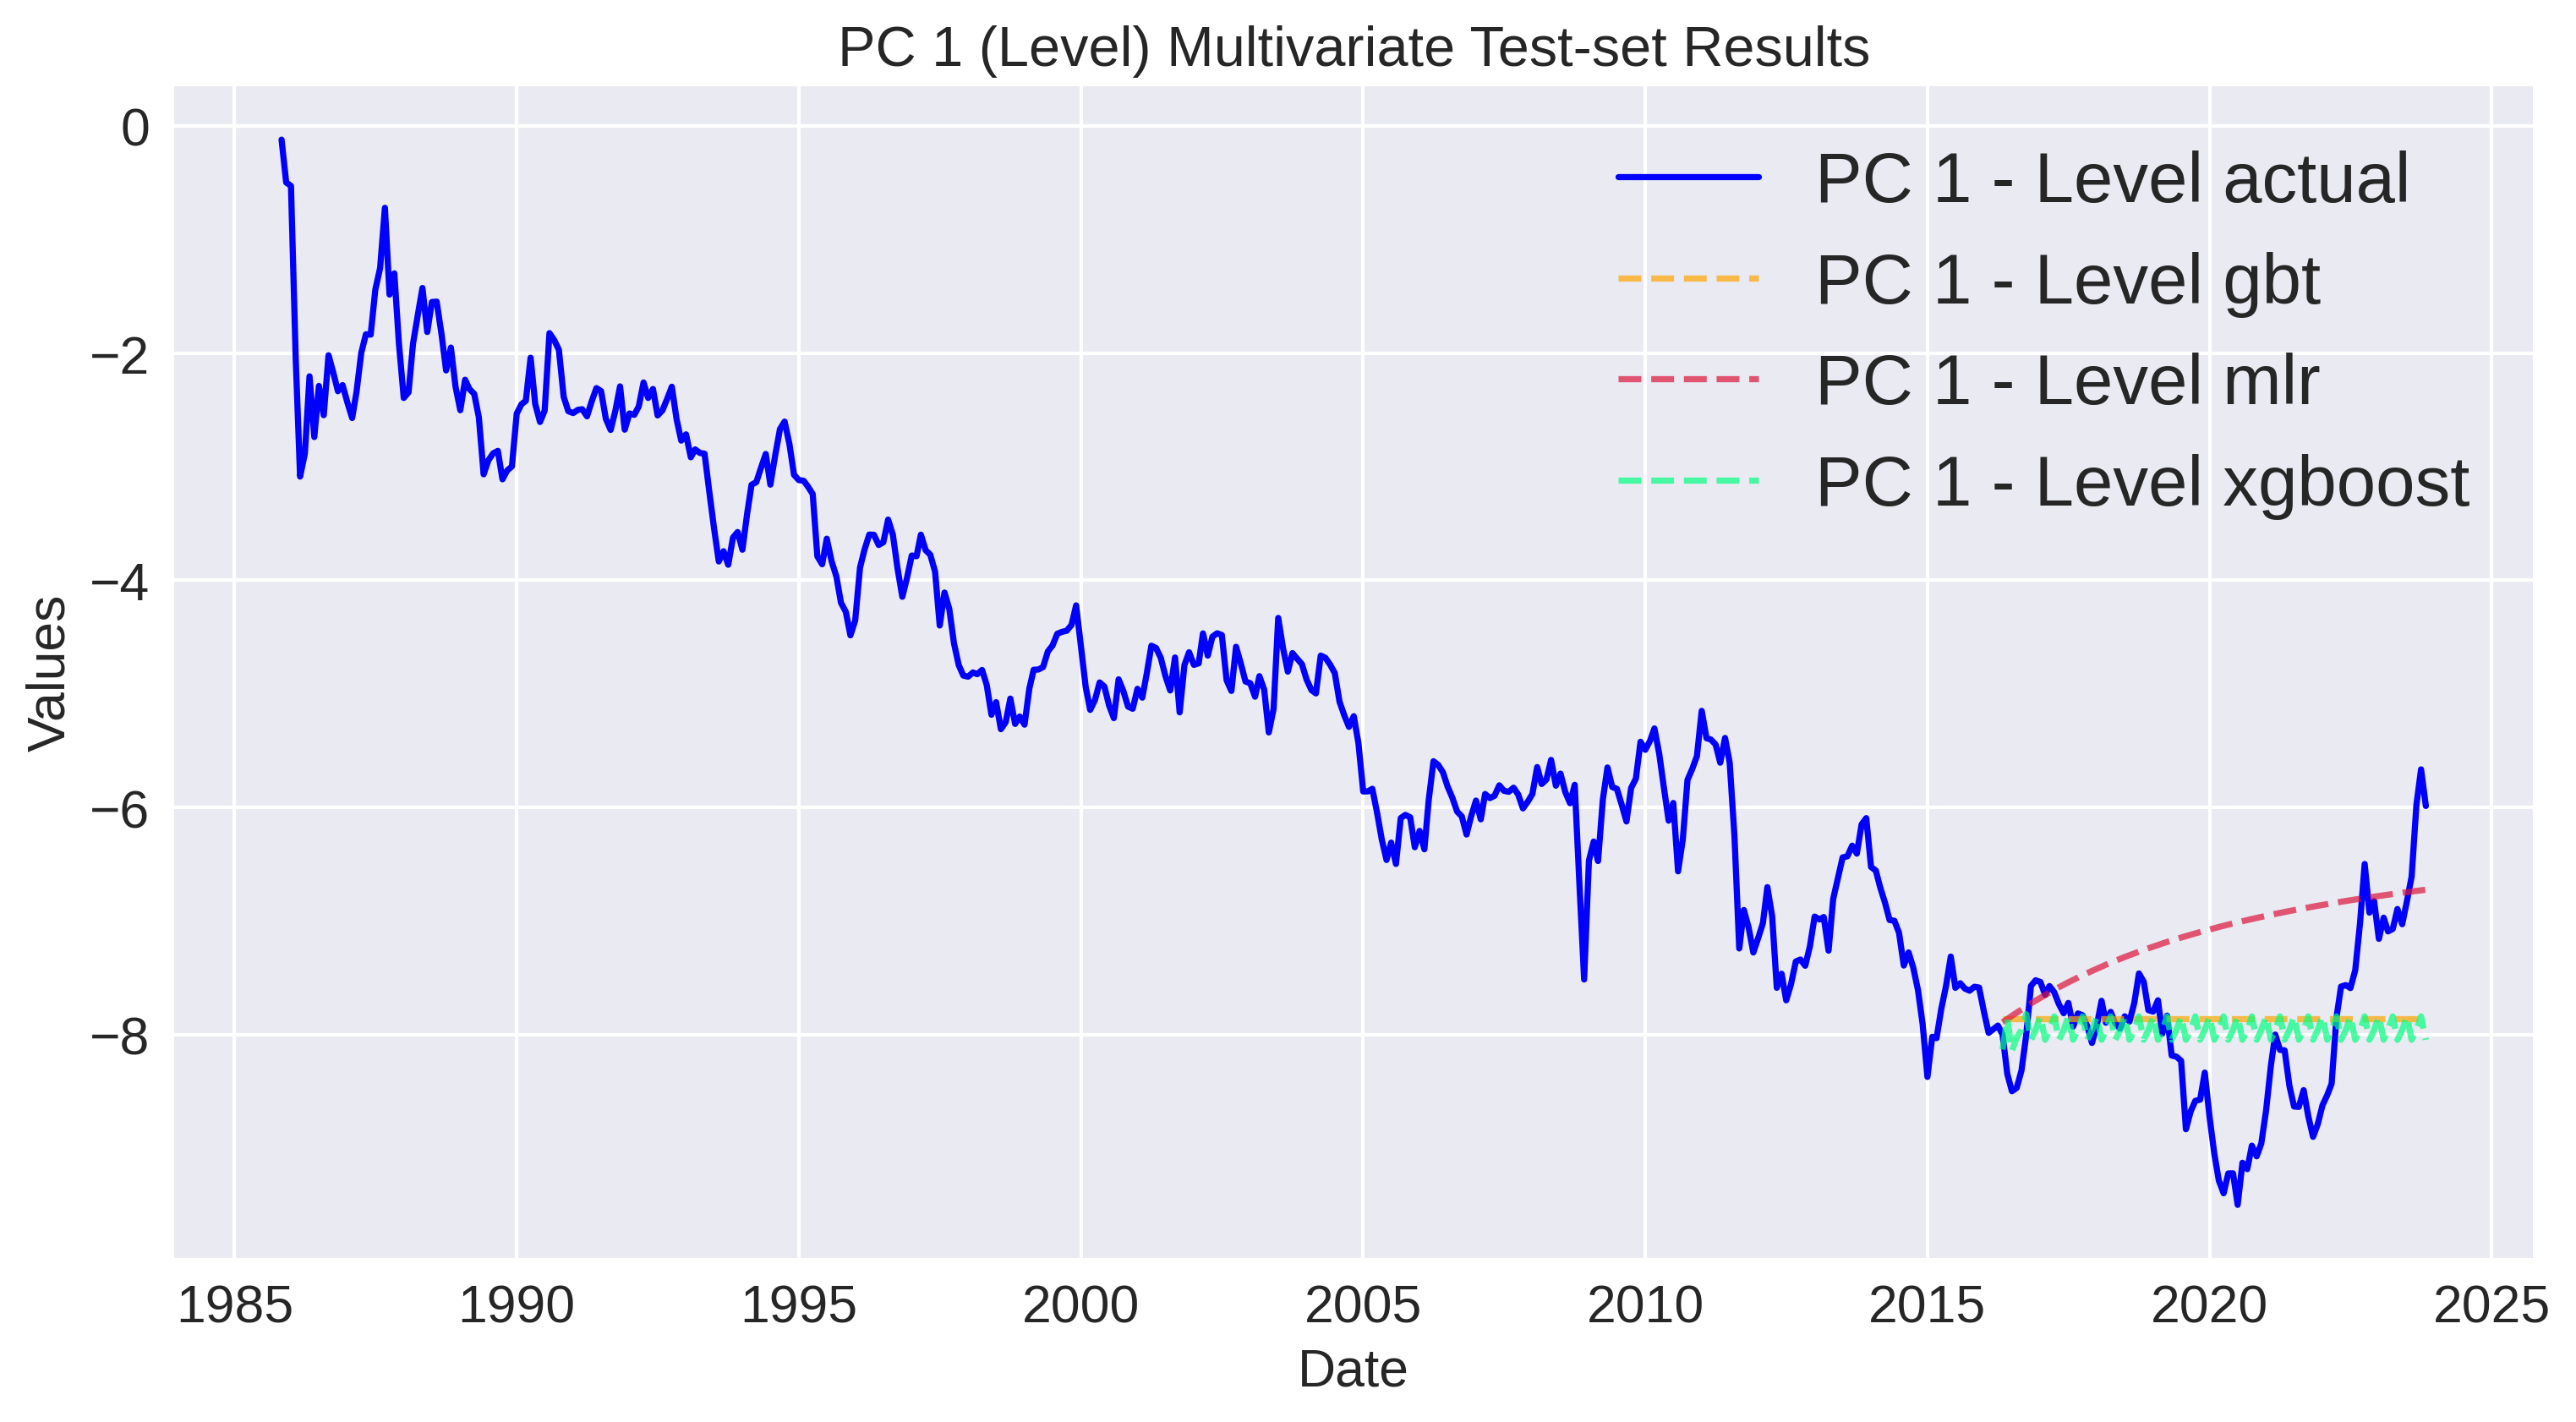

In [21]:
# not plotting both series at the same time because they have significantly different scales
mvf.plot_test_set(series='PC 1 - Level',put_best_on_top=True)
plt.title('PC 1 (Level) Multivariate Test-set Results',size=16)
plt.show()

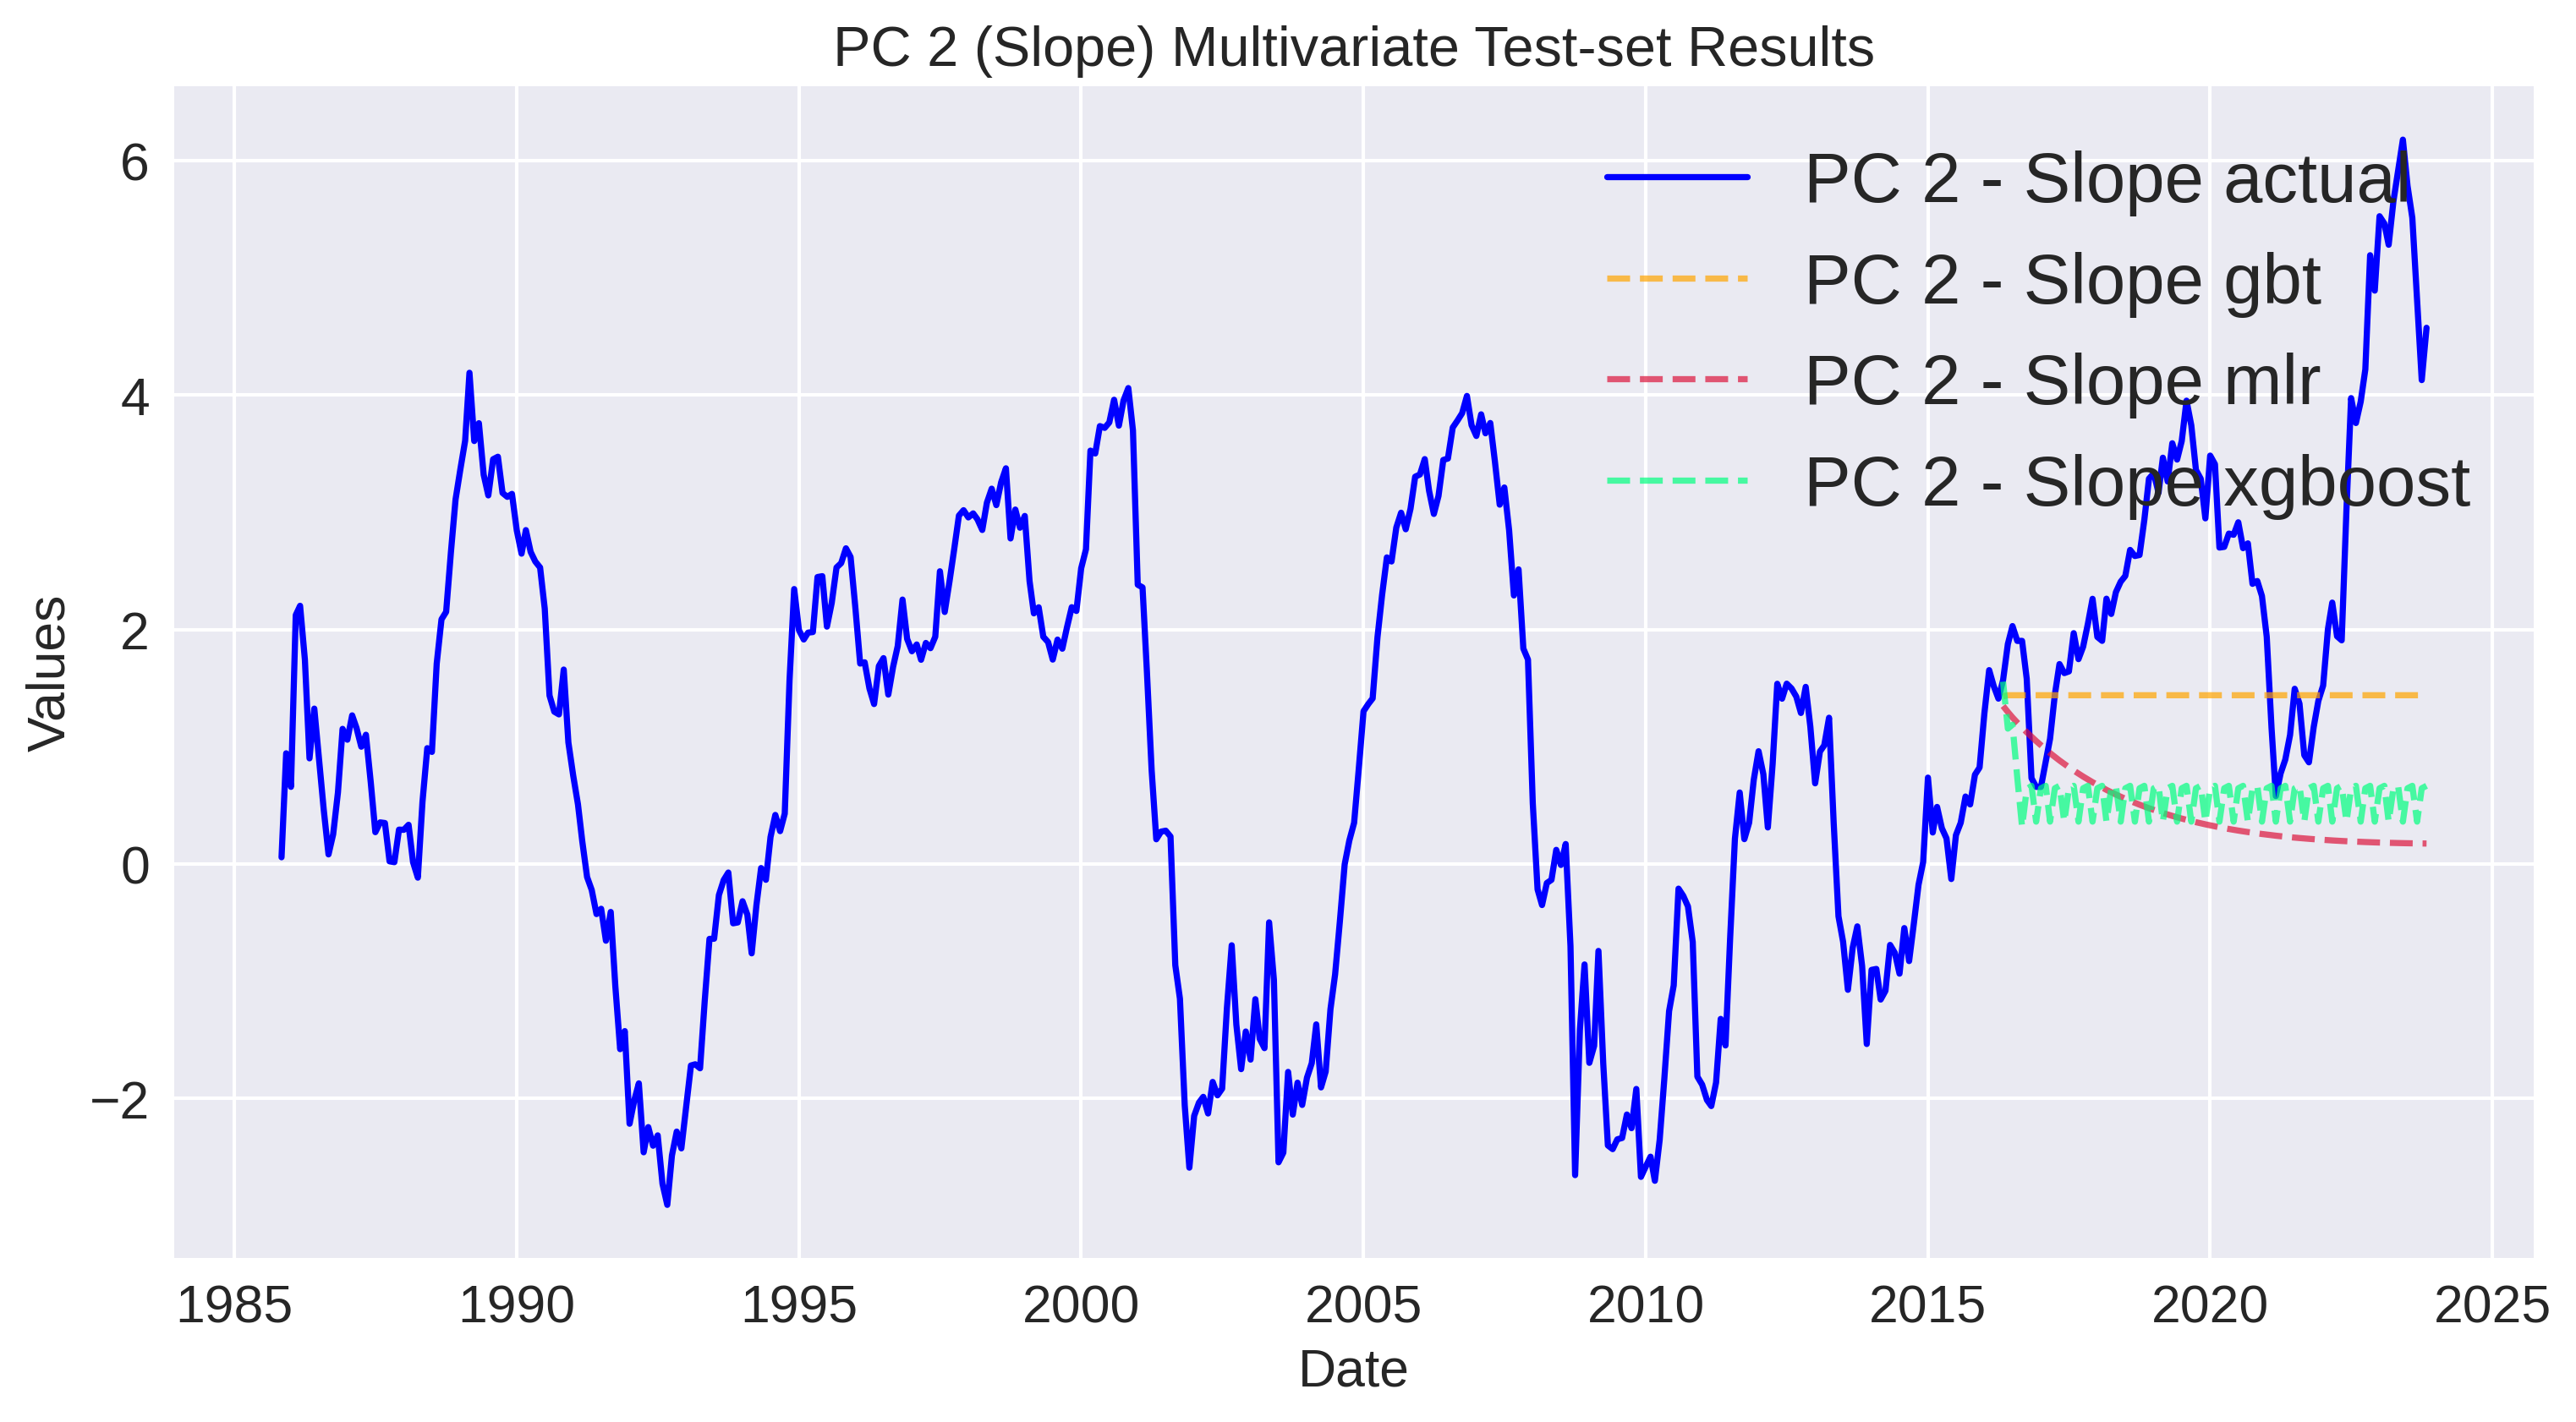

In [22]:
mvf.plot_test_set(series='PC 2 - Slope',put_best_on_top=True)
plt.title('PC 2 (Slope) Multivariate Test-set Results',size=16)
plt.show()

In [23]:
pd.options.display.max_colwidth = 100
results = mvf.export('model_summaries')
results[
    [
        'ModelNickname',
        'Series',
        'HyperParams',
        'TestSetRMSE',
        'TestSetR2',
        'InSampleRMSE',
        'InSampleR2',
        'Lags'
    ]
]

,ModelNickname,Series,HyperParams,TestSetRMSE,TestSetR2,InSampleRMSE,InSampleR2,Lags
0,gbt,PC 1 - Level,"{'max_depth': 3, 'max_features': 'sqrt'}",0.7863,-0.0240,0.1732,0.9931,1
1,mlr,PC 1 - Level,{'normalizer': None},1.1557,-1.2120,0.2576,0.9845,3
2,xgboost,PC 1 - Level,"{'n_estimators': 150, 'scale_pos_weight': 5, 'learning_rate': 0.2, 'gamma': 0, 'subsample': 0.9}",0.7803,-0.0084,0.0307,0.9998,1
3,gbt,PC 2 - Slope,"{'max_depth': 3, 'max_features': 'sqrt'}",1.8777,-0.8377,0.2777,0.9799,1
4,mlr,PC 2 - Slope,{'normalizer': None},2.7378,-2.9071,0.3908,0.9605,3
5,xgboost,PC 2 - Slope,"{'n_estimators': 150, 'scale_pos_weight': 5, 'learning_rate': 0.2, 'gamma': 0, 'subsample': 0.9}",2.5503,-2.3902,0.0492,0.9994,1
